In [112]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector,plot_histogram
from qiskit_aer import AerSimulator

def SendState(qc1, qc2, qc1_name):
    ''' This function takes the output of a circuit qc1 (made up only of x and 
        h gates and initializes another circuit qc2 with the same state
    ''' 
    
    # Quantum state is retrieved from qasm code of qc1
    qs = qc1.qasm().split(sep=';')[4:-1]

    # Process the code to get the instructions
    for index, instruction in enumerate(qs):
        qs[index] = instruction.lstrip()

    # Parse the instructions and apply to new circuit
    for instruction in qs:
        if instruction[0] == 'x':
            old_qr = int(instruction[5:-1])
            qc2.x(qr[old_qr])
        elif instruction[0] == 'h':
            old_qr = int(instruction[5:-1])
            qc2.h(qr[old_qr])
        elif instruction[0] == 'm': # exclude measuring:
            pass
        else:
            raise Exception('Unable to parse instruction')

Exercise 1: Design the key-encoding quantum circuit. 
For this, first create a 8-bit classical register and a 8-qubit quantum register.
and then merge them. Hereinafter we will refer to this circuit as ‘Alice quantum circuit’. 

In [113]:
# Complete the code to create a n-bit classical register and a n-qubit quantum register
# Use 'QuantumRegister' and 'ClassicalRegister'

n = 8  # note for a local backend n can go as up as 23, after that it raises a Memory Error

qr = QuantumRegister(n, name='qr')
cr = ClassicalRegister(n,name='cr')

# Quantum circuit for alice state

aliceqc = QuantumCircuit(qr,cr, name='Alice')

#aliceqc.draw('mpl')


Exercise 2: Generate a random 8-bit quantum key. 
For this, first generate a random number using ‘np.random.randint’ and then convert it into binary using ‘np.binary_repr’.
Print the key both in decimal and binary forms.  Run the code several times to make sure the key is randomly generated at every run. 
Finally, encode the key as qubits using the ‘Alice quantum circuit’.  For this, apply an X gate to the corresponding qubit when the digit in the key is equal to ‘1’. 
Plot the resulting circuit.

In [114]:
# Generate a random number in the range of n qubits 

alice_key = np.random.randint(0,high=2**n)

#print the key in decimal form

print(alice_key)

218


In [115]:
# Convert key to binary for encoding

alice_key = np.binary_repr(alice_key,n)

#print the key in binary form

print(alice_key)

11011010


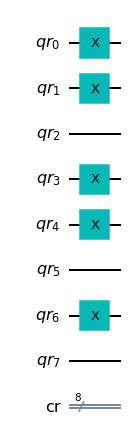

In [116]:
# Encode the key as qubits using the 'Alice quantum circuit'. Apply X when the digit is equal to 1

for index, digit in enumerate(alice_key):
    if digit == '1':
        aliceqc.x(qr[index])
        
        
#plot the circuit

aliceqc.draw('mpl')

Exercise 3: Measure every qubit in the key according to the following basis [X,Z,Z,Z,X,Z,X,X] where X stands for the diagonal basis and Z for the computational basis. This corresponds to applying a H-gate to the qubit when measured in the diagonal basis. Print the resulting circuit. Next, propose a code generating a random measurement basis for every qubit.

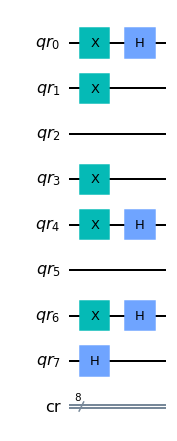

In [117]:

#ATTENTION: This case will give an error if you use a number of qubits 'n' different from 8

alice_measurement_basis_table = ['X','Z','Z','Z','X','Z','X','X']        

for index in range(len(qr)):       
    if alice_measurement_basis_table[index] == 'X':   
        aliceqc.h(qr[index])    

#plot the circuit

aliceqc.draw('mpl')

['Z', 'X', 'X', 'X', 'Z', 'X', 'Z', 'X']


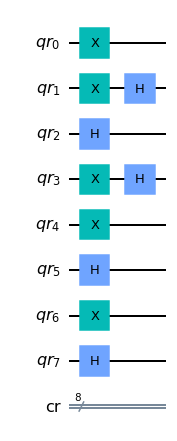

In [118]:
# Quantum circuit for alice state - random basis

aliceqc2 = QuantumCircuit(qr,cr, name='Alice')

for index, digit in enumerate(alice_key):
    if digit == '1':
        aliceqc2.x(qr[index])
        
random_alice_measurement_basis_table = []   # Create empty basis table     

for index in range(len(qr)):       
    if 0.5 < np.random.random():   
        aliceqc2.h(qr[index])   
        random_alice_measurement_basis_table.append('X')   
    else:
        random_alice_measurement_basis_table.append('Z')    
        
print(random_alice_measurement_basis_table)

#plot the circuit

aliceqc2.draw('mpl')



Exercise 4: Define 'Bob's circuit' as a copy of Alice's circuit using the SendState funcion. Generate and apply random measurement basis to Bob's circuit as you did for Alice's. Measure all qubits in Bob, run the simulation and plot the histogram. Is alice_key within the results of the histogram?

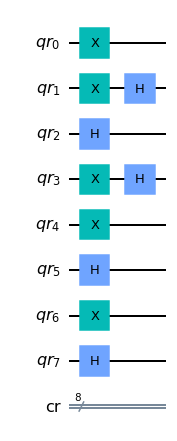

In [119]:
#define bobqc and ist initial state as a copy of Alice state

bobqc = QuantumCircuit(qr,cr, name='Bob')

SendState(aliceqc2, bobqc, 'Alice')    

bobqc.draw('mpl')

['X', 'X', 'Z', 'Z', 'X', 'X', 'Z', 'Z']


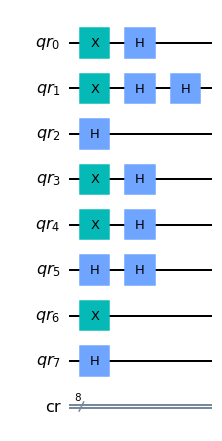

In [120]:
# Quantum circuit for bob state - random basis - complete the code

random_bob_measurement_basis_table = []   # Create empty basis table     

for index in range(len(qr)):       
    if 0.5 < np.random.random():   
        bobqc.h(qr[index])   
        random_bob_measurement_basis_table.append('X')   
    else:
        random_bob_measurement_basis_table.append('Z')    
        
print(random_bob_measurement_basis_table)

bobqc.draw('mpl')    

In [121]:
# Measure all qubits in bob 

for index in range(len(qr)): 
    bobqc.measure(qr[index],cr[index])

sim = AerSimulator()

compiled_circuit = transpile(bobqc, sim)

job=sim.run(compiled_circuit)

result = job.result()

counts = result.get_counts()

#plot_histogram(counts) 


Exercise 5: Execute the proposed code. Once Alice and Bob's keys have been exchanged and qubits measured with different basis discarded, are the remaining keys equal (percentage of similarity = 1)?. Does this result depends on the number of bits in the key? How many bits needs your key to be able to send the key over long distances given the photon losses in optical fibers? 

In [122]:
bob_keys=[x[::-1] for x in counts.keys()] # key elements reversed so that first qubit is the first element of the list

bob_key=bob_keys[0] #Bob key candidate

print(bob_key)
print(alice_key)


11100011
11011010


In [123]:
#execute the following code and observe and comment the results

keep = []
discard = []

for qubit, basis in enumerate(zip(random_alice_measurement_basis_table, random_bob_measurement_basis_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}\n" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}\n" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)
print("Mantained qubits {}".format(keep))
print("Discarded qubits {}".format(discard))



Different choice for qubit: 0, Alice has Z, Bob has X

Same choice for qubit: 1, basis: X

Different choice for qubit: 2, Alice has X, Bob has Z

Different choice for qubit: 3, Alice has X, Bob has Z

Different choice for qubit: 4, Alice has Z, Bob has X

Same choice for qubit: 5, basis: X

Same choice for qubit: 6, basis: Z

Different choice for qubit: 7, Alice has X, Bob has Z

Mantained qubits [1, 5, 6]
Discarded qubits [0, 2, 3, 4, 7]


In [124]:
acc = 0

for bit in zip(alice_key, bob_key):
    if bit[0] == bit[1]:
        acc += 1

print('Percentage of qubits to be discarded according to table comparison: ', len(discard)/n)
print('Measurement convergence by additional chance: ', acc/n) 

Percentage of qubits to be discarded according to table comparison:  0.625
Measurement convergence by additional chance:  0.5


In [125]:
new_alice_key = [alice_key[qubit] for qubit in keep]
print(new_alice_key)

new_bob_key = [bob_key[qubit] for qubit in keep]
print(new_bob_key)

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('Percentage of similarity between the keys: ', acc/len(new_alice_key))      

['1', '0', '1']
['1', '0', '1']
Percentage of similarity between the keys:  1.0


Exercise 6: Include a third circuit (Spy circuit), between Alice and Bob. The spy circuit measures using its own random basis. How can you detect that the key has been intercepted?

['Z', 'Z', 'X', 'X', 'X', 'Z', 'Z', 'X']


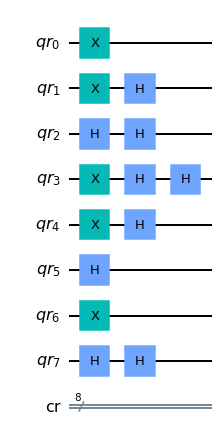

In [126]:
#define the spy circuit (SendState to copy aliceqc2) and a random measurement basis

spyqc = QuantumCircuit(qr,cr,name='Spy')
SendState(aliceqc2,spyqc,'Alice')

random_spy_measurement_basis_table=[]

for index in range(len(qr)):
    if 0.5 < np.random.random():
        spyqc.h(qr[index])
        random_spy_measurement_basis_table.append('X')
    else:
        random_spy_measurement_basis_table.append('Z')

print(random_spy_measurement_basis_table)

spyqc.draw('mpl')


['Z', 'X', 'Z', 'X', 'Z', 'Z', 'Z', 'Z']


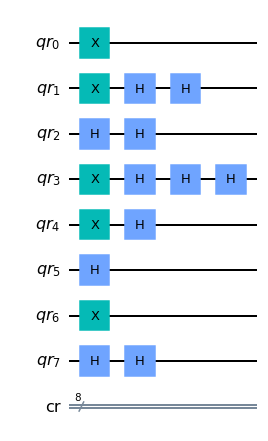

In [127]:
#define bob's circuit and the random measurement basis 

bobqc2 = QuantumCircuit(qr,cr,name='Bob')
SendState(spyqc,bobqc2,'Spy')

random_bob_measurement_basis_table = []   # Create empty basis table     

for index in range(len(qr)):       
    if 0.5 < np.random.random():   
        bobqc2.h(qr[index])   
        random_bob_measurement_basis_table.append('X')   
    else:
        random_bob_measurement_basis_table.append('Z')    
        
print(random_bob_measurement_basis_table)

bobqc2.draw('mpl')    



In [129]:
# Measure all qubits in Bob and run de simulation

for index in range(len(qr)): 
    bobqc2.measure(qr[index], cr[index])

sim = AerSimulator()

compiled_circuit = transpile(bobqc2, sim)

job=sim.run(compiled_circuit)

result = job.result()

counts = result.get_counts()

bob_keys=[x[::-1] for x in counts.keys()] 

bob_key=bob_keys[0]

keep = []
discard = []

for qubit, basis in enumerate(zip(random_alice_measurement_basis_table, random_bob_measurement_basis_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}\n" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}\n" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)
print("Mantained qubits {}".format(keep))
print("Discarded qubits {}".format(discard))

new_alice_key = [alice_key[qubit] for qubit in keep]
print(new_alice_key)

new_bob_key = [bob_key[qubit] for qubit in keep]
print(new_bob_key)

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('Percentage of similarity between the keys: ', acc/len(new_alice_key))      


Same choice for qubit: 0, basis: Z

Same choice for qubit: 1, basis: X

Different choice for qubit: 2, Alice has X, Bob has Z

Same choice for qubit: 3, basis: X

Same choice for qubit: 4, basis: Z

Different choice for qubit: 5, Alice has X, Bob has Z

Same choice for qubit: 6, basis: Z

Different choice for qubit: 7, Alice has X, Bob has Z

Mantained qubits [0, 1, 3, 4, 6]
Discarded qubits [2, 5, 7]
['1', '1', '1', '1', '1']
['1', '1', '0', '1', '1']
Percentage of similarity between the keys:  0.8
